In [1]:
import os
import cv2
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, Activation, Add, Lambda

In [2]:
def load_dataset_as_patches(hr_root, lr_root, patch_size_lr=48, stride=24, scale_factor=2, max_patches_per_image=None):
    """
    Loads HR and LR image patches from separate folders for EDSR training.
    Extracts patches from both LR and HR images maintaining the scale factor relationship.

    Parameters:
        hr_root (str): Root path to HR images.
        lr_root (str): Root path to LR images.
        patch_size_lr (int): Size of LR patches (HR patches will be patch_size_lr * scale_factor).
        scale_factor (int): The scale factor (2, 3, or 4).
        stride (int): Stride for patch extraction.
        max_patches_per_image (int): Maximum patches to extract per image (None for all).

    Returns:
        X (np.ndarray): Low-resolution patches (model input).
        Y (np.ndarray): High-resolution patches (target).
    """
    
    def add_padding(image, patch_size, stride):
        """Add padding to ensure full coverage."""
        
        h, w, c = image.shape
        
        # Calcular cuánto padding se necesita
        pad_h = (patch_size - (h % stride)) % stride if h % stride != 0 else 0
        pad_w = (patch_size - (w % stride)) % stride if w % stride != 0 else 0
        
        # Agregar padding extra para asegurar cobertura completa
        pad_h = max(pad_h, patch_size - stride)
        pad_w = max(pad_w, patch_size - stride)
        
        # Padding reflejado (mirror) para mantener continuidad
        padded_img = np.pad(
            image, 
            ((0, pad_h), (0, pad_w), (0, 0)), 
            mode='reflect'
        )
        
        return padded_img
    
    if not os.path.exists(hr_root) or not os.path.exists(lr_root):
        raise ValueError("Both HR and LR root directories must exist.")
    
    patch_size_hr = patch_size_lr * scale_factor
    X, Y = [], []

    def get_all_image_paths(root):
        image_paths = []
        for dirpath, _, filenames in os.walk(root):
            for filename in filenames:
                if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
                    image_paths.append(os.path.join(dirpath, filename))
        return sorted(image_paths)

    hr_paths = get_all_image_paths(hr_root)
    lr_paths = get_all_image_paths(lr_root)

    # Match HR and LR images by filename
    hr_dict = {os.path.basename(p): p for p in hr_paths}
    lr_dict = {os.path.basename(p): p for p in lr_paths}
    common_filenames = sorted(set(hr_dict.keys()) & set(lr_dict.keys()))

    if not common_filenames:
        raise ValueError("No matching filenames found between HR and LR directories.")

    total_patches = 0
    
    for fname in common_filenames:
        hr_img = cv2.imread(hr_dict[fname], cv2.IMREAD_COLOR)
        lr_img = cv2.imread(lr_dict[fname], cv2.IMREAD_COLOR)

        if hr_img is None or lr_img is None:
            continue

        # Convert to RGB and normalize
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        lr_h, lr_w, _ = lr_img.shape
        hr_h, hr_w, _ = hr_img.shape
        
        # Add padding to ensure full coverage
        hr_img = add_padding(hr_img, patch_size_hr, stride)
        lr_img = add_padding(lr_img, patch_size_lr, stride)

        # Generate patches
        patches_this_image = 0
        
        for i in range(0, lr_h - patch_size_lr + 1, stride):
            for j in range(0, lr_w - patch_size_lr + 1, stride):
                # Extract LR patch
                lr_patch = lr_img[i:i+patch_size_lr, j:j+patch_size_lr]
                
                # Extract corresponding HR patch
                hr_i = i * scale_factor
                hr_j = j * scale_factor
                
                if hr_i + patch_size_hr <= hr_h and hr_j + patch_size_hr <= hr_w:
                    hr_patch = hr_img[hr_i:hr_i+patch_size_hr, hr_j:hr_j+patch_size_hr]
                    
                    X.append(lr_patch)
                    Y.append(hr_patch)
                    
                    patches_this_image += 1
                    total_patches += 1
                    
                    if max_patches_per_image and patches_this_image >= max_patches_per_image:
                        break
            
            if max_patches_per_image and patches_this_image >= max_patches_per_image:
                break

    if not X:
        raise ValueError("No patches could be extracted. Check your patch size and image dimensions.")

    X_array = np.array(X)
    Y_array = np.array(Y)
    
    print(f"Extracted {total_patches} patch pairs from {len(common_filenames)} images")
    print(f"LR patches shape: {X_array.shape}")
    print(f"HR patches shape: {Y_array.shape}")

    return X_array, Y_array

In [66]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

class EDSR:
    def __init__(self):
        self.model = None
        self.scale_factor = None
        self.trained = False

    def setup_model(
            self, 
            scale_factor=2, 
            channels=3, 
            num_res_blocks=16, 
            num_filters=64, 
            res_scaling=0.1, 
            learning_rate=1e-4, 
            loss="mean_absolute_error", 
            from_pretrained=False, 
            pretrained_path=None):
        """Set up the EDSR model, either by loading a pretrained model or building a new one."""
        
        self.scale_factor = scale_factor
        
        if from_pretrained:
            if pretrained_path is None or not os.path.isfile(pretrained_path):
                raise FileNotFoundError(f"Pretrained model file not found at {pretrained_path}")
            
            self.model = load_model(pretrained_path, custom_objects={"psnr": psnr, "ssim": ssim})
            self.trained = True
            print(f"Loaded pretrained model from {pretrained_path}")
        else:
            self._build_model(scale_factor, channels, num_res_blocks, num_filters, res_scaling)
            self._compile_model(learning_rate, loss)

    def _residual_block(self, x, num_filters, res_scaling):
        """Build a residual block without batch normalization (key feature of EDSR)."""
        
        shortcut = x
        
        # First conv layer
        x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        x = Activation("relu")(x)
        
        # Second conv layer
        x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        
        # Scale the residual
        if res_scaling != 1.0:
            x = Lambda(lambda t: t * res_scaling)(x)
        
        # Add shortcut connection
        x = Add()([x, shortcut])
        
        return x

    def _upsampling_block(self, x, scale_factor, num_filters):
        """Create upsampling block using sub-pixel convolution."""
        
        if scale_factor == 2:
            x = Conv2D(num_filters * 4, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
        elif scale_factor == 3:
            x = Conv2D(num_filters * 9, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 3))(x)
        elif scale_factor == 4:
            # Two 2x upsampling blocks
            x = Conv2D(num_filters * 4, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
            x = Conv2D(num_filters * 4, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
        else:
            raise ValueError(f"Scale factor {scale_factor} not supported. Use 2, 3, or 4.")
        
        return x

    def _build_model(self, scale_factor, channels, num_res_blocks, num_filters, res_scaling):
        """Construct the EDSR model architecture using functional API."""
        
        inputs = Input(shape=(None, None, channels), name="input")
        
        # Initial convolution (head)
        x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
        
        # Store for global residual connection
        head_output = x
        
        # Residual blocks (body)
        for i in range(num_res_blocks):
            x = self._residual_block(x, num_filters, res_scaling)
        
        # Final convolution of the body
        x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        
        # Global residual connection
        x = Add()([x, head_output])
        
        # Upsampling blocks (tail)
        x = self._upsampling_block(x, scale_factor, num_filters)
        
        # Final convolution to produce RGB output
        outputs = Conv2D(channels, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        
        self.model = Model(inputs, outputs, name="EDSR")

    def _compile_model(self, learning_rate, loss):
        """Compile the model with Adam optimizer and specified loss, including PSNR and SSIM metrics."""
        
        optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        self.model.compile(optimizer=optimizer, loss=loss, metrics=[psnr, ssim])
        self.model.summary()

    def fit(self, X_train, Y_train, X_val, Y_val, batch_size=16, epochs=300, use_augmentation=False):
        """Train the model using optional image data augmentation and standard callbacks."""
        
        if self.model is None:
            raise ValueError("Model is not built yet.")

        devices = tf.config.list_physical_devices("GPU")
        if devices:
            print("Training on GPU:", devices[0].name)
        else:
            print("Training on CPU")

        callbacks = [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1)
        ]

        if use_augmentation:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.05,
                height_shift_range=0.05,
                horizontal_flip=True
            )
            train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)
            val_gen = datagen.flow(X_val, Y_val, batch_size=batch_size)

            self.model.fit(
                train_gen,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=epochs,
                validation_data=val_gen,
                validation_steps=len(X_val) // batch_size,
                callbacks=callbacks
            )
        else:
            self.model.fit(
                X_train, Y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, Y_val),
                callbacks=callbacks
            )

        self.trained = True

    def evaluate(self, X_test, Y_test):
        """Evaluate the model on test data and print loss, PSNR, and SSIM."""
        
        if not self.trained:
            raise RuntimeError("Model has not been trained.")

        results = self.model.evaluate(X_test, Y_test)
        print(f"Loss: {results[0]:.4f}, PSNR: {results[1]:.2f} dB, SSIM: {results[2]:.4f}")
        
        return results
    
    def super_resolve_image(self, lr_img_path, patch_size_lr=48, stride=24):
        """
        Super-resolves a single LR image from a file path using patch-wise prediction and reconstructs the HR image.
        
        Args:
            lr_img_path (str): Path to the input LR image.
            patch_size_lr (int): Size of LR patches.
            stride (int): Stride for patch extraction.
        
        Returns:
            np.ndarray: Super-resolved HR image, float32 in [0, 1].
        """
        
        if not self.trained:
            raise RuntimeError("Model has not been trained.")

        # --- Read and preprocess the LR image ---
        lr_img = cv2.imread(lr_img_path, cv2.IMREAD_COLOR)
        
        if lr_img is None:
            raise ValueError(f"Could not read image at {lr_img_path}")
        
        # Convert BGR (OpenCV default) to RGB and normalize to [0, 1]
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # --- Calculate HR patch size based on scale factor ---
        patch_size_hr = patch_size_lr * self.scale_factor

        # --- Padding to ensure full coverage when extracting patches ---
        h, w, c = lr_img.shape
        
        pad_h = (patch_size_lr - (h % stride)) % stride if h % stride != 0 else 0
        pad_w = (patch_size_lr - (w % stride)) % stride if w % stride != 0 else 0
        
        pad_h = max(pad_h, patch_size_lr - stride)
        pad_w = max(pad_w, patch_size_lr - stride)
        
        lr_img_padded = np.pad(
            lr_img,
            ((0, pad_h), (0, pad_w), (0, 0)),
            mode='reflect'
        )
        
        padded_h, padded_w, _ = lr_img_padded.shape

        # --- Prepare output HR image and weight map for overlap-averaging ---
        hr_img_shape = (padded_h * self.scale_factor, padded_w * self.scale_factor, c)
        hr_img = np.zeros(hr_img_shape, dtype=np.float32)
        weight_map = np.zeros(hr_img_shape, dtype=np.float32)

        # --- Extract LR patches, predict HR patches, and reconstruct HR image ---
        for i in range(0, padded_h - patch_size_lr + 1, stride):
            for j in range(0, padded_w - patch_size_lr + 1, stride):
                # Extract LR patch
                lr_patch = lr_img_padded[i:i+patch_size_lr, j:j+patch_size_lr]
                # Add batch dimension for model prediction
                lr_patch_batch = np.expand_dims(lr_patch, axis=0)
                # Predict HR patch using the model
                sr_patch = self.model.predict(lr_patch_batch, verbose=0)[0]
                # Calculate the position in the HR image
                hr_i = i * self.scale_factor
                hr_j = j * self.scale_factor
                # Add predicted patch to the HR image
                hr_img[hr_i:hr_i+patch_size_hr, hr_j:hr_j+patch_size_hr] += sr_patch
                # Update weight map for overlap-averaging
                weight_map[hr_i:hr_i+patch_size_hr, hr_j:hr_j+patch_size_hr] += 1.0

        # --- Normalize by the weight map to average overlapping regions ---
        weight_map[weight_map == 0] = 1.0
        hr_img /= weight_map

        # --- Remove padding to return image with original upscaled size ---
        out_h = h * self.scale_factor
        out_w = w * self.scale_factor
        hr_img = hr_img[:out_h, :out_w]

        # --- Clip values to [0, 1] and return ---
        sr_img = np.clip(hr_img, 0.0, 1.0)
        
        return sr_img

    def save(self, directory="models/EDSR"):
        """Save the trained model with a timestamp in the specified directory."""
        
        if not self.trained:
            raise RuntimeError("Cannot save an untrained model.")

        os.makedirs(directory, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        path = os.path.join(directory, f"EDSR_x{self.scale_factor}_{timestamp}.h5")
        self.model.save(path)
        print(f"Model saved to {path}")

In [41]:
PATCH_SIZE_LR = 24
STRIDE = 12
SCALE_FACTOR = 2

In [ ]:
X, Y = load_dataset_as_patches("../../data/images/HR", "../../data/images/LR", patch_size_lr=PATCH_SIZE_LR, stride=STRIDE, scale_factor=SCALE_FACTOR)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True, random_state=42)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

Extracted 274104 patch pairs from 846 images
LR patches shape: (274104, 24, 24, 3)
HR patches shape: (274104, 48, 48, 3)
X_train shape: (222023, 24, 24, 3), Y_train shape: (222023, 48, 48, 3)
X_val shape: (24670, 24, 24, 3), Y_val shape: (24670, 48, 48, 3)
X_test shape: (27411, 24, 24, 3), Y_test shape: (27411, 48, 48, 3)


In [6]:
model = EDSR()

model.setup_model(scale_factor=SCALE_FACTOR, num_res_blocks=16, num_filters=64)

Model: "EDSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['input[0][0]']                  
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                            

In [9]:
model.fit(X_train, Y_train, X_val, Y_val, batch_size=16, epochs=1, use_augmentation=True)

Training on GPU: /physical_device:GPU:0
13876/13876 [==============================] - 404s 29ms/step - loss: 0.0566 - psnr: 23.7789 - ssim: 0.4974 - val_loss: 0.0516 - val_psnr: 24.4212 - val_ssim: 0.5529 - lr: 1.0000e-04


In [10]:
model.evaluate(X_test, Y_test)

857/857 [==============================] - 15s 18ms/step - loss: 0.0340 - psnr: 27.6311 - ssim: 0.6902
Loss: 0.0340, PSNR: 27.63 dB, SSIM: 0.6902


[0.03401588648557663, 27.63112449645996, 0.6901789307594299]

In [11]:
model.save()

Model saved to models/EDSR\EDSR_x2_20250625_221609.h5


In [67]:
pretrained_model = EDSR()

pretrained_model.setup_model(scale_factor=SCALE_FACTOR, from_pretrained=True, pretrained_path="models/EDSR\EDSR_x2_20250625_221609.h5")

Loaded pretrained model from models/EDSR\EDSR_x2_20250625_221609.h5


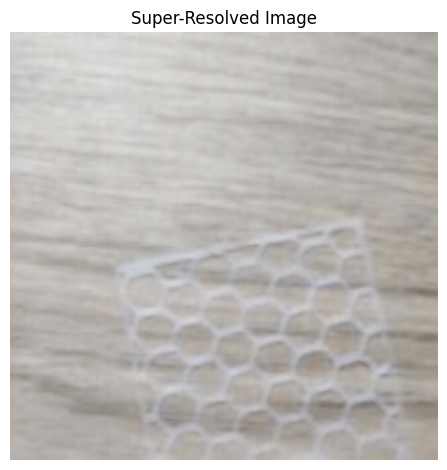

In [70]:
sr_image = pretrained_model.super_resolve_image("low_z_offset.png", patch_size_lr=PATCH_SIZE_LR, stride=STRIDE)

plt.imshow(sr_image)
plt.axis("off")
plt.title("Super-Resolved Image")
plt.tight_layout()
plt.show()